## Importing packages

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
#import pydicom

import os
import glob
import h5py
import shutil

#import imgaug as aug

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
#import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

import itertools

color = sns.color_palette()

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Using TensorFlow backend.


In [3]:
## Reading data

In [4]:
# Define path to the data directory
data_dir = os.path.join('..','D:\\Covid\\Final data\\All')


In [5]:
# Set folder names as labels
covid_cases = data_dir + '/' + 'Covid/*'
noncovid_cases = data_dir + '/' + 'Non-Covid/*'

# Get the list of all the images
covid_cases = glob.glob(covid_cases)
noncovid_cases = glob.glob(noncovid_cases)


## Preparing train, test and val data

# Train data

In [6]:
# List that are going to contain validation images data and the corresponding labels
all_data = []
all_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# All Cases
cases = [covid_cases, noncovid_cases]
for case_num in range(2):
    for img in cases[case_num]:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (150,150))
        img = img.astype(np.float32)/255.
        label = to_categorical(case_num, num_classes=2)
        all_data.append(img)
        all_label.append(label)

# Convert the list into numpy arrays
all_data = np.array(all_data)
all_label = np.array(all_label)

print("Total number of examples: ", all_data.shape)
print("Total number of labels:", all_label.shape)


Total number of examples:  (4140, 150, 150, 3)
Total number of labels: (4140, 2)


In [7]:
# Split dataset into train, test and validate
from sklearn.model_selection import train_test_split
tr_data, test_data, tr_label, test_label = train_test_split(all_data, all_label, test_size=0.20,shuffle=True)
number_of_tr = tr_data.shape[0]
number_of_test = test_data.shape[0]
print('Train', number_of_tr)
print('Test',number_of_test)

# from sklearn.model_selection import train_test_split
# train_data, val_data, train_label, val_label = train_test_split(tr_data, tr_label, test_size=0.20, shuffle=True)
# number_of_train = train_data.shape[0]
# number_of_validate = val_data.shape[0]
# print('Train', number_of_train)
# print('Validate',number_of_validate)

Train 3312
Test 828


## VGG16

In [8]:
from keras.layers import Dense,GlobalAveragePooling2D,Dropout
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import optimizers
from keras import regularizers

base_model=VGG16(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
avg_pool=GlobalAveragePooling2D()(x)
layer_1=Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.005))(avg_pool) #we add dense layers so that the model can learn more complex functions and classify for better results.
layer_2=Dropout(0.5)(layer_1)
layer_3=Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.005))(layer_2) #dense layer 2
layer_4=Dropout(0.5)(layer_1)
layer_5=Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.005))(layer_4) #dense layer 3
preds=Dense(2,activation='sigmoid')(layer_3) #final layer with softmax activation

In [9]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:10]:
    layer.trainable=False
for layer in model.layers[10:]:
    layer.trainable=True
    
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [10]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            mode='auto',
                                            verbose=1,
                                            restore_best_weights=True)

In [11]:
history = model.fit(tr_data, tr_label,
                    shuffle = True,
                    validation_split = 0.2,
                    batch_size=64,
                    epochs=40,
                    verbose=1,
                    callbacks=[learning_rate_reduction])

Train on 2649 samples, validate on 663 samples
Epoch 1/40
2649/2649 [==============================] - 12s 5ms/step - loss: 5.9054 - accuracy: 0.5693 - val_loss: 5.1569 - val_accuracy: 0.6561
Epoch 2/40
2649/2649 [==============================] - 8s 3ms/step - loss: 4.7391 - accuracy: 0.6440 - val_loss: 4.3661 - val_accuracy: 0.6456
Epoch 3/40
2649/2649 [==============================] - 8s 3ms/step - loss: 4.0233 - accuracy: 0.7452 - val_loss: 3.7619 - val_accuracy: 0.7662
Epoch 4/40
2649/2649 [==============================] - 8s 3ms/step - loss: 3.4369 - accuracy: 0.8324 - val_loss: 3.1668 - val_accuracy: 0.8869
Epoch 5/40
2649/2649 [==============================] - 8s 3ms/step - loss: 2.9690 - accuracy: 0.9075 - val_loss: 2.8939 - val_accuracy: 0.8808
Epoch 6/40
2649/2649 [==============================] - 8s 3ms/step - loss: 2.6052 - accuracy: 0.9502 - val_loss: 2.5742 - val_accuracy: 0.9140
Epoch 7/40
2649/2649 [==============================] - 8s 3ms/step - loss: 2.3174 - acc

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


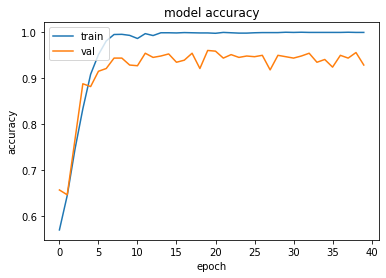

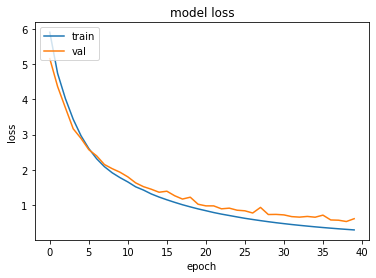

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Overall Accuracy:  0.9420289855072463
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       410
           1       0.92      0.96      0.94       418

    accuracy                           0.94       828
   macro avg       0.94      0.94      0.94       828
weighted avg       0.94      0.94      0.94       828

Overall sensitivity: 0.9420289855072463
Overall Fscore: 0.941989373712987
[15 33]
[33 15]
[377 403]
[403 377]
Sensitivity:  [0.9195122  0.96411483]
Specificty:  [0.96411483 0.9195122 ]
Overall SPecificity= 0.9418135138289182
Precision:  [0.96173469 0.92431193]
Recall:  [0.9195122  0.96411483]
F-score:  [0.94014963 0.94379391]
Classwise acc:  [0.94202899 0.94202899]


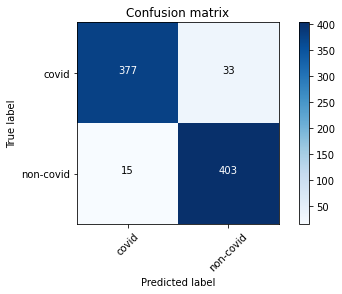

In [13]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
classes=['covid', 'non-covid']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    
       
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Predict the values from the validation dataset
Y_pred = model.predict(test_data)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_label, axis = 1) 


# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(cm, classes)
# Find accuracy
from sklearn import metrics
print("Overall Accuracy: ", metrics.accuracy_score(Y_true, Y_pred_classes))
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print(classification_report(Y_true, Y_pred_classes, labels=[0,1]))
print("Overall sensitivity:",recall_score(Y_true, Y_pred_classes, average='weighted'))
print("Overall Fscore:" , f1_score(Y_true, Y_pred_classes, average='weighted'))

FP = cm.sum(axis=0) - np.diag(cm)  
print(FP)
FN = cm.sum(axis=1) - np.diag(cm)
print(FN)
TP = np.diag(cm)
print(TP)
TN = cm.sum() - (FP + FN + TP)
print(TN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity: ", TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificty: ", TNR)
print("Overall SPecificity=", np.mean(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision: ", PPV)
rec= TP/(TP+FN)
print("Recall: ", rec)
#F-score
fs=(2*PPV*rec)/(PPV+rec)
print("F-score: ", fs)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# #Auc curve
# from sklearn.metrics import roc_auc_score
# roc_auc_score(Y_true, Y_pred,multi_class='ovo')
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Classwise acc: ", ACC)
